<a href="https://colab.research.google.com/github/wronatime/fedUserAssignmentNANCY/blob/main/consensus_attack_EuCNC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# Load Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/PhD/PROGETTI_PROPOSTE/Horizon Europe 23-24/NANCY2/WP Activities/WP5/PAPER EUCNC2025/"

# Load Data
df = pd.read_csv('ML-MATT-CompetitionQT2021_train.csv',sep=';')

num_features = df.shape[1] - 1

print(f"Total number of features: {num_features}")

print(f"Lista features: {list(df.columns)}")

/content/drive/.shortcut-targets-by-id/1XmDX0TE43mmoBN4vMBaAwUlOxWJMvghu/NANCY2/WP Activities/WP5/PAPER EUCNC2025
Total number of features: 13
Lista features: ['Time', 'CellName', 'PRBUsageUL', 'PRBUsageDL', 'meanThr_DL', 'meanThr_UL', 'maxThr_DL', 'maxThr_UL', 'meanUE_DL', 'meanUE_UL', 'maxUE_DL', 'maxUE_UL', 'maxUE_UL+DL', 'Unusual']


# Network Graph

In [ ]:
import networkx as nx

def createNetworkGraph(nodes):
  # Create a graph
  G = nx.Graph()

  # Make sure nodes are ordered
  nodes = sorted(nodes)

  # Add nodes
  G.add_nodes_from(nodes)

  # Add edges in a circular fashion
  edges = []
  for i in range(len(nodes)-1):
    couple = (nodes[i],nodes[i+1])
    edges.append(couple)

  # the last is connected to the first
  last_couple = (nodes[-1],nodes[0])

  edges.append(last_couple)

  # Add edges to form a circular structure
  G.add_edges_from(edges)

  return G

def plotGraph(G):

  # Draw the graph
  pos = nx.circular_layout(G)  # Circular layout for nodes
  nx.draw(
      G,
      pos,
      with_labels=True,
      node_color='white',
      edge_color='black',
      node_size=2000,
      font_color='black',
      font_weight='bold',
      edgecolors = 'black'
  )

  # Show the plot
  plt.title("Circular Graph", fontsize=16)
  plt.show()

In [ ]:
'''
Test graph functions
'''

#nodes = np.random.choice(np.arange(1, 11), size=5, replace=False).tolist()
nodes = [1,2,3,4]
G = createNetworkGraph(nodes)
plotGraph(G)

# Consensus Algorithm

In [ ]:
# Funzione per calcolare il controllo u_i
def computeResilientControl(x, feat, elem, k, G):

  u = 0
  tau = 0.05
  neighbors = list(G.neighbors(elem))  # Vicini di i

  for j in neighbors:

    x_i = x[elem][feat][k]
    x_j = x[j][feat][k]

    if np.abs(x_i-x_j) <= tau:
      w = 1
    else:
      #print(f'Node {elem} thinks Node {j} is a malicious one!\n')
      w = 0
    u += w*(x_j - x_i)  # Somma (x_j - x_i) per ogni vicino
  return u

def consensus(x, G, feature_names, federation, iters, attackers):


  T_s = 0.1  # Sampling time

  feature_names = list(feature_names)

  for k in range(1,iters):
    for feat in feature_names:
      for elem in federation:

        if elem not in attackers:
          x_cur = x[elem][feat][k-1]
          u = computeResilientControl(x, feat, elem, k-1, G)
          x_cur = x_cur + T_s*u

          x[elem][feat][k] = x_cur
        else:   # the attacker has no dynamics
          x[elem][feat][k] = x[elem][feat][k-1]



  return x

# Feature Importance Averaging

In [ ]:
def meanFeatureConsensus(BS, federation, feature_names, attackers):

  '''
  Standard average
  '''

  feature_names = list(feature_names)

  nf = len(feature_names)

  # Create Graph
  G = createNetworkGraph(federation)

  # Provide initial state for the features
  x = {}

  # Provide iterations for consensus
  iterations = 150

  for elem in federation:
    x[elem] = {}
    for i in range(nf):
      x[elem][feature_names[i]] = np.zeros(iterations)
      x[elem][feature_names[i]][0] = BS[elem]['model'].feature_importances_[i]


  #data_normal = {}
  #data_normal[normal] = {}
  #for feat in feature_names:
  #  data_normal[normal][feat] = x[normal][feat][0]

  #cur_data = data_normal[normal]

  #min_value = min(cur_data.values())

  #worst_feature = min(cur_data, key=cur_data.get)

  #print(f"WORST FEATURE FOR BS {normal}: {worst_feature}")


  data_attack = {}
  for elem in attackers:
    data_attack[elem] = {}
    for feat in feature_names:
      data_attack[elem][feat] = x[elem][feat][0]

  for elem in attackers:

    cur_data = data_attack[elem]
    # Find the highest value in the dictionary
    max_value = max(cur_data.values())

    best_feature = max(cur_data, key=cur_data.get)

    print(f"BEST FEATURE: {best_feature}")

    '''
    I want to put the new lowest value to the most important feature
    remembering that the sum must be equal to 1!

    alpha_attack < 1/(1+nf)

    '''

    beta = 0.01

    alpha_attack = beta*(1/(nf))
    others = (1-alpha_attack)/(nf-1)

    # Transform the dictionary: set 1 for the keys with the lowest value, 0 for others
    transformed_data = {key: alpha_attack if value == max_value else others for key,
                      value in cur_data.items()}

    for feat in feature_names:
      x[elem][feat][0] = transformed_data[feat]


  x_history = consensus(x, G, feature_names, federation, iterations, attackers)

  data = {}
  for elem in federation:
    if elem not in attackers:
      for feat in feature_names:
        data[feat] = x_history[elem][feat][-1]

  frmv = min(data, key=data.get)
  print(f'Less important feature for node {elem} : {frmv}')


  return frmv, x_history

# Samples

In [ ]:
# NUMERO DI CAMPIONI CONTENUTI DA OGNI BS
for i in range(1,11):
  if i == 1:
    # utilizzare solo 1 comprenderebbe anche la base station 10
    tmp = (len(df[df['CellName'].str.startswith(('1A','1B','1C'))]))
  else:
    tmp = (len(df[df['CellName'].str.startswith(str(i))]))
  print("Base Station " + str(i) + ":" + str(tmp) +"samples")

Base Station 1:3359samples
Base Station 2:1116samples
Base Station 3:3355samples
Base Station 4:3431samples
Base Station 5:3392samples
Base Station 6:6744samples
Base Station 7:6550samples
Base Station 8:3397samples
Base Station 9:2215samples
Base Station 10:3345samples


# Decide who are the Base Stations in the federation out of the total 10



In [ ]:
attackers = [1,2,3]

normal = [4,5,6,7,8,9,10]

normal_node = 6

active_BS_indices = attackers + normal

num_active_BS = len(active_BS_indices)

# Main Algorithm

In [ ]:
# Main with consensus

BS = {}

# Consensus round with all data
cr = {}

# Current federation
federation = active_BS_indices.copy()

default_columns_to_drop = ['Unusual','Time','CellName']
y_label = 'Unusual'


for index in active_BS_indices:
  BS[index] = {}
  BS[index]['Precision'] = 0
  BS[index]['Recall'] = 0
  BS[index]['Test Accuracy'] = 0
  BS[index]['F1 Score'] = 0
  BS[index]['malicious'] = 0

stop = 0

# List of eliminated BS during the process
elim = []

round = 1

columns_to_drop = default_columns_to_drop

while stop == 0:
  print("------- FEDERATION TRAINING - ROUND ", round, "-------")

  elim = []

  # for each Base Station in the federation
  for node in federation:

    if node == 1:
      # utilizzare solo 1 comprenderebbe anche la base station 10
      filtered_df = df[df['CellName'].str.startswith(('1A','1B','1C'))]
    else:
      filtered_df = df[df['CellName'].str.startswith(str(node))]

    # Clean
    X = filtered_df.drop(columns_to_drop, axis=1)
    y = filtered_df[y_label]

    BS[node]['X_pandas'] = X
    BS[node]['X_pandas'] = y

    feature_names = X.columns

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                          test_size=0.2,
                                                          random_state=42)

    # Normalization
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    BS[node]['X_train'] = X_train
    BS[node]['X_test'] = X_test
    BS[node]['y_train'] = y_train
    BS[node]['y_test'] = y_test

    model = RandomForestClassifier(random_state=42)
    BS[node]['model'] = model


    print(f"Training Base Station: {node}")

    BS[node]['model'].fit(BS[node]['X_train'], BS[node]['y_train'])

    # Prediction
    y_pred = BS[node]['model'].predict(BS[node]['X_test'])

    # F1score
    if node not in attackers and BS[node]["F1 Score"] > f1_score(BS[node]['y_test'], y_pred):
      elim.append(node)
      print("\t BASE STATION", node, "LEFT THE FEDERATION")
      print("\n")
    else:
      p,r,f1,_ = precision_recall_fscore_support(BS[node]['y_test'],
                                                   y_pred,
                                                   average='binary')
      BS[node]['Precision'] = p
      BS[node]['Recall'] = r
      BS[node]['F1 Score'] = f1
      BS[node]['Test Accuracy'] = accuracy_score(BS[node]['y_test'], y_pred)

  for elem in elim:
    federation.remove(elem)

  # STOP CONDITION
  # If only the attacker remains in the federation then the process stop
  if len(federation) == len(attackers):
    stop = 1
    print('\n++++++++++ONLY ATTACKERS REMAINS IN THE FEDERATION++++++++++')
    print("\n++++++++++STOP FEDERATION TRAINING AT ROUND %.0f++++++++++" %(round))

  else:
    frmv, history = meanFeatureConsensus(BS, federation, feature_names,
                                         attackers)
    columns_to_drop.append(frmv)
    print(f"\n++++++++++FEATURE REMOVED: {frmv}++++++++++")
    print("\n")

  print("\n\n")
  cr[round] = history
  round +=1


------- FEDERATION TRAINING - ROUND  1 -------
Training Base Station: 1
Training Base Station: 2
Training Base Station: 3
Training Base Station: 4
Training Base Station: 5
Training Base Station: 6
Training Base Station: 7
Training Base Station: 8
Training Base Station: 9
Training Base Station: 10
BEST FEATURE: meanUE_UL
BEST FEATURE: meanUE_UL
BEST FEATURE: meanUE_UL
Less important feature for node 10 : maxUE_DL

++++++++++FEATURE REMOVED: maxUE_DL++++++++++





------- FEDERATION TRAINING - ROUND  2 -------
Training Base Station: 1
Training Base Station: 2
Training Base Station: 3
Training Base Station: 4
Training Base Station: 5
	 BASE STATION 5 LEFT THE FEDERATION


Training Base Station: 6
Training Base Station: 7
Training Base Station: 8
Training Base Station: 9
	 BASE STATION 9 LEFT THE FEDERATION


Training Base Station: 10
BEST FEATURE: meanUE_UL
BEST FEATURE: meanUE_UL
BEST FEATURE: meanUE_UL
Less important feature for node 10 : maxUE_UL

++++++++++FEATURE REMOVED: maxUE_UL++

In [ ]:
print(f"F1-Score: {BS[normal_node]['F1 Score']}")

F1-Score: 0.9583333333333334


# PLOT CONSENSUS ROUNDS

In [ ]:
def plotEvolution(x, attackers):


  # Num features
  for index in x:
    feat_names = list(x[index].keys())
    nf = len(feat_names)

  # Create a figure with nf subplots (one for each feature)
  fig, axes = plt.subplots(nf, 1, figsize=(10, 50))



  # Loop over each feature and plot it on the corresponding subplot
  for i in range(nf):  # We have nf features
      ax = axes[i]

      # Plot the time evolution of this feature for all indexes
      for index in x:
          if index not in attackers:
            ax.plot(x[index][feat_names[i]], label=f"Node {index}")
          else:
            ax.plot(x[index][feat_names[i]], label=f"Attacker (Node {index})")
      # Add labels and title for each subplot
      ax.set_title(f"Time Evolution of Feature {feat_names[i]}")
      ax.set_xlabel("Time Step")
      ax.set_ylabel("Feature Value")
      ax.legend(loc='upper right')
      ax.grid(True)

  # Adjust the layout to avoid overlap
  plt.tight_layout()

  # Show the plot
  plt.show()


def plotConsensusFeature(data, all_BS, attackers, feature_name):

  plt.figure()

  for node in all_BS:
    signal = data[node][feature_name]
    if node in attackers:
      label = r"BS$_{{{}}} \,\, (attacker)$".format(node)
    else:
      label = r"BS$_{{{}}}$".format(node)
    plt.plot(signal,label=label)

  plt.xlabel('Time Step')
  plt.ylabel(f'Importance Score of Feature {feature_name}')
  plt.grid(True)
  plt.legend()
  plt.savefig('Figures/consensus_evolution.pdf')

  #plt.show()



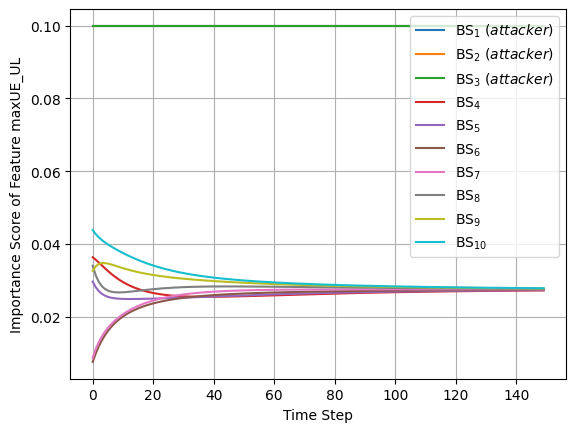

In [ ]:
round = 1
data = cr[round]

#plotEvolution(data, attackers)


plotConsensusFeature(data, active_BS_indices, attackers, 'maxUE_UL')


# Save Results

In [ ]:
# Open a CSV file for writing

# Save scores up to the fifth digit after the comma

with open('Results/consensus_attack_EuCNC.csv', 'w', newline='') as csvfile:
    print(active_BS_indices)
    # Create a CSV writer
    csvwriter = csv.writer(csvfile, delimiter=',')

    # Write header
    csvwriter.writerow(["BS", "Precision", "Recall", "F1 Score", "Test_Acc"])

    # Loop through each base station
    i=1
    for node in active_BS_indices:
        print(node)
        # Calculate precision, recall, and F1 score
        precision = BS[node]['Precision']
        recall = BS[node]['Recall']
        f1 = BS[node]['F1 Score']
        print(f"BS{node}, F1 Score: {f1}")
        acc = BS[node]['Test Accuracy']

        # Write the results to the CSV file
        if node != attack_node:
          csvwriter.writerow([i, f"{precision:.5f}", f"{recall:.5f}", f"{f1:.5f}",f"{acc:.5f}"])
        i+=1